# Low-Light Image Enhancement

**Project:** Image Pre-processing for Roadside Detection in Autonomous Vehicles  
**Student:** Kaylan Wang    
**Date:** November 2025

## 1. Setup and Imports

In [1]:
# Install required packages (run this cell first if needed)
!pip install opencv-python numpy matplotlib scipy

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

# Set matplotlib to display plots inline
%matplotlib inline

# Set figure size default
plt.rcParams['figure.figsize'] = (15, 5)

print("✓ All packages imported successfully!")
print(f"OpenCV version: {cv2.__version__}")

✓ All packages imported successfully!
OpenCV version: 4.12.0


## 2. Core Algorithm Implementations

### 2.1 Histogram Equalization

In [3]:
def histogram_equalization(image):
    """
    Apply histogram equalization to enhance low-light images.
    For color images, applies to V channel in HSV color space.
    """
    if len(image.shape) == 2:
        # Grayscale image
        equalized = cv2.equalizeHist(image)
    else:
        # Color image - convert to HSV and equalize V channel
        img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        img_hsv[:, :, 2] = cv2.equalizeHist(img_hsv[:, :, 2])
        equalized = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)
    
    return equalized

print("✓ Histogram Equalization function defined")

✓ Histogram Equalization function defined


### 2.2 Gamma Correction

In [4]:
def gamma_correction(image, gamma=0.5):
    """
    Apply gamma correction with specified gamma value.
    
    Args:
        image: Input image (BGR format)
        gamma: Gamma value for correction
    """
    # Build lookup table for gamma correction
    # inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** gamma) * 255 
                      for i in np.arange(0, 256)]).astype("uint8")
    
    # Apply gamma correction using lookup table
    corrected = cv2.LUT(image, table)
    return corrected

print("✓ Gamma Correction function defined")

✓ Gamma Correction function defined


## 3. Parameter Selection Methodology

### 3.1 Image Analysis Function

**Methodology:**
1. Compute image statistics (mean, std, percentiles)
2. Assess brightness level
3. Recommend gamma value based on analysis

**Selection criteria:**
- Very dark (mean < 50): γ = 0.4
- Dark (mean < 80): γ = 0.5
- Moderately dark (mean < 120): γ = 0.6
- Fairly bright: γ = 0.8

In [5]:
def analyze_image_brightness(image):
    """
    Analyze image to determine optimal parameters.
    """
    # Convert to grayscale for analysis
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Compute statistics
    mean_intensity = np.mean(gray)
    std_intensity = np.std(gray)
    median_intensity = np.median(gray)
    
    # Compute percentiles
    p10 = np.percentile(gray, 10)
    p50 = np.percentile(gray, 50)
    p90 = np.percentile(gray, 90)
    
    # Determine brightness level
    is_lowlight = mean_intensity < 80
    is_very_lowlight = mean_intensity < 50
    
    # Recommend gamma based on analysis
    if is_very_lowlight:
        recommended_gamma = 0.4
        reason = "Very low mean intensity detected"
    elif is_lowlight:
        recommended_gamma = 0.5
        reason = "Low mean intensity detected"
    elif mean_intensity < 120:
        recommended_gamma = 0.6
        reason = "Moderately low mean intensity"
    else:
        recommended_gamma = 0.8
        reason = "Image already fairly bright"
    
    # Assess contrast
    if std_intensity < 30:
        contrast_level = "Low contrast"
    elif std_intensity < 60:
        contrast_level = "Moderate contrast"
    else:
        contrast_level = "High contrast"
    
    return {
        'mean_intensity': mean_intensity,
        'std_intensity': std_intensity,
        'median_intensity': median_intensity,
        'p10': p10,
        'p50': p50,
        'p90': p90,
        'is_lowlight': is_lowlight,
        'recommended_gamma': recommended_gamma,
        'recommendation_reason': reason,
        'contrast_level': contrast_level
    }

print("✓ Image analysis function defined")

✓ Image analysis function defined


### 3.2 Optimal Gamma Selection

**Methodology:**
1. Test multiple gamma values systematically
2. Compute quality metrics for each
3. Select gamma that maximizes quality score
4. Quality score balances brightness vs over-exposure

In [6]:
def select_optimal_gamma(image, gamma_range=(0.3, 0.4, 0.5, 0.6, 0.7)):
    """
    Test multiple gamma values and select optimal one.
    """
    results = {}
    
    for gamma in gamma_range:
        enhanced = gamma_correction(image, gamma)
        gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)
        
        mean_int = np.mean(gray)
        std_int = np.std(gray)
        overexposed = np.sum(gray > 245) / gray.size * 100
        underexposed = np.sum(gray < 10) / gray.size * 100
        
        # Quality score: target mean ~130, penalize over-exposure
        brightness_score = 100 - abs(mean_int - 130)
        overexposure_penalty = overexposed * 5
        quality_score = brightness_score - overexposure_penalty
        
        results[gamma] = {
            'mean_intensity': mean_int,
            'std_intensity': std_int,
            'overexposed_pct': overexposed,
            'underexposed_pct': underexposed,
            'quality_score': quality_score
        }
    
    # Select gamma with highest quality score
    optimal_gamma = max(results.keys(), key=lambda g: results[g]['quality_score'])
    return optimal_gamma, results

print("✓ Optimal gamma selection function defined")

✓ Optimal gamma selection function defined


## 4. Testing on Dataset

Recommended gamma: 0.4


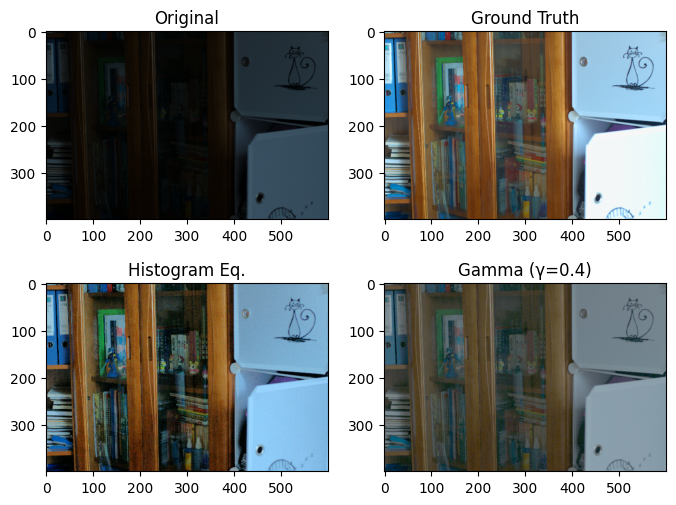

In [7]:
# Example: Load and process a real image
# Uncomment and modify the path to test on your dataset

real_image_path = "datasets/low/1.png"
ground_truth_path = "datasets/high/1.png"  

real_image = cv2.imread(real_image_path)
ground_truth_image = cv2.imread(ground_truth_path)
if real_image is not None:
    # Analyze image
    analysis = analyze_image_brightness(real_image)
    print(f"Recommended gamma: {analysis['recommended_gamma']}")
    
    # Apply methods
    hist_eq = histogram_equalization(real_image)
    gamma_enh = gamma_correction(real_image, analysis['recommended_gamma'])
    
    # Display results
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    axes[0,0].imshow(cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB))
    axes[0,0].set_title('Original')
    axes[0,1].imshow(cv2.cvtColor(ground_truth_image, cv2.COLOR_BGR2RGB))
    axes[0,1].set_title('Ground Truth')
    axes[1,0].imshow(cv2.cvtColor(hist_eq, cv2.COLOR_BGR2RGB))
    axes[1,0].set_title('Histogram Eq.')
    axes[1,1].imshow(cv2.cvtColor(gamma_enh, cv2.COLOR_BGR2RGB))
    axes[1,1].set_title(f'Gamma (γ={analysis["recommended_gamma"]})')
 
    plt.show()


## 5. Batch Process Dataset

Process all images in the low_light folder with both histogram equalization and gamma correction.

In [9]:
from pathlib import Path
from tqdm import tqdm

# Setup paths
low_light_dir = Path("datasets/low_light")
gt_dir = Path("datasets/ground_truth")
corrected_he_dir = Path("datasets/corrected_he")
corrected_gamma_dir = Path("datasets/corrected_gamma")

corrected_he_dir.mkdir(parents=True, exist_ok=True)
corrected_gamma_dir.mkdir(parents=True, exist_ok=True)

# Get all image files
image_extensions = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]
image_files = [f for ext in image_extensions for f in low_light_dir.glob(ext)]

print(f"Found {len(image_files)} images to process\n")

Found 92 images to process



In [10]:
# Process with Histogram Equalization
print("Processing with Histogram Equalization...")
for img_path in tqdm(image_files, desc="Histogram Equalization"):
    img = cv2.imread(str(img_path))
    if img is not None:
        corrected = histogram_equalization(img)
        cv2.imwrite(str(corrected_he_dir / img_path.name), corrected)

print(f"✓ Saved {len(list(corrected_he_dir.glob('*')))} images to {corrected_he_dir}")

Processing with Histogram Equalization...


Histogram Equalization: 100%|██████████| 92/92 [00:16<00:00,  5.69it/s]

✓ Saved 92 images to datasets/corrected_he


In [11]:
# Process with Gamma Correction
print("\nProcessing with Gamma Correction...")
gamma_values = []

for img_path in tqdm(image_files, desc="Gamma Correction"):
    img = cv2.imread(str(img_path))
    if img is not None:
        analysis = analyze_image_brightness(img)
        gamma = analysis['recommended_gamma']
        gamma_values.append(gamma)
        corrected = gamma_correction(img, gamma)
        cv2.imwrite(str(corrected_gamma_dir / img_path.name), corrected)

print(f"✓ Saved {len(list(corrected_gamma_dir.glob('*')))} images to {corrected_gamma_dir}")
print(f"Gamma values used: min={min(gamma_values):.2f}, max={max(gamma_values):.2f}, mean={np.mean(gamma_values):.2f}")


Processing with Gamma Correction...


Gamma Correction: 100%|██████████| 92/92 [00:40<00:00,  2.26it/s]

✓ Saved 92 images to datasets/corrected_gamma
Gamma values used: min=0.40, max=0.50, mean=0.40


## 6. Visual Comparison Examples

Display example corrections showing ground truth, synthetic low-light, and corrected images.

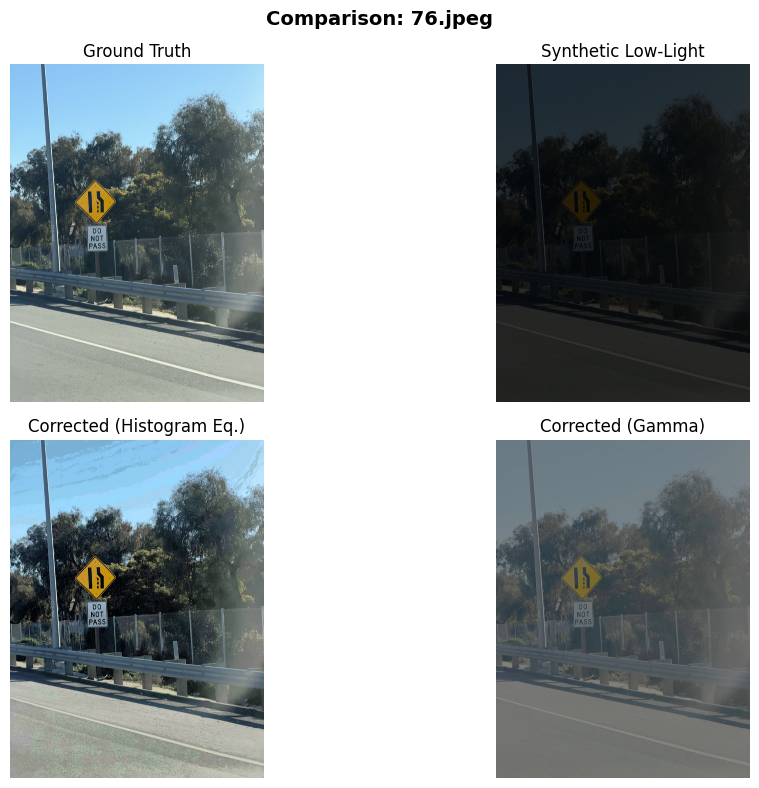


Showing comparison for 76.jpeg



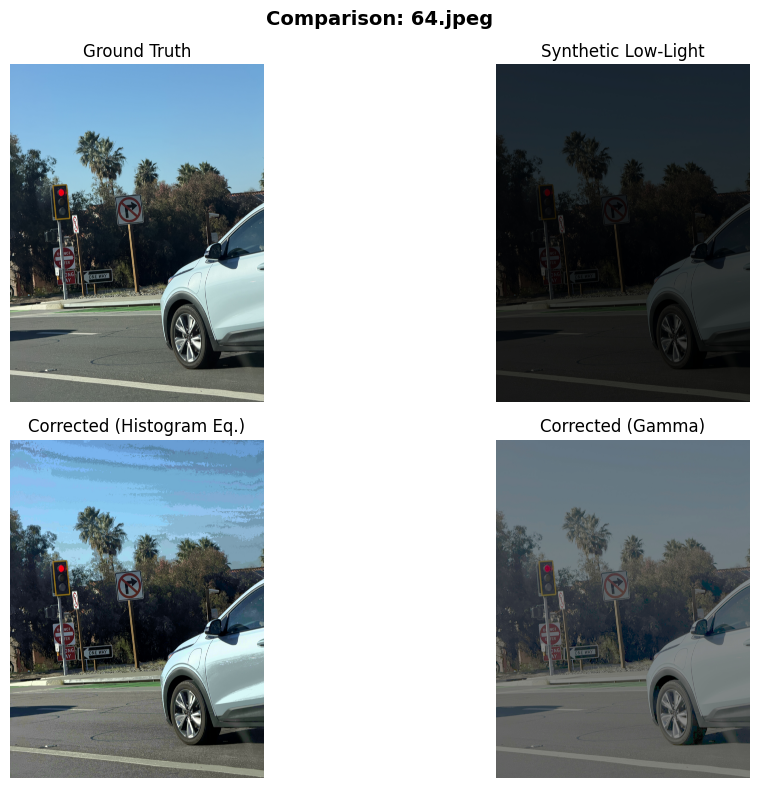


Showing comparison for 64.jpeg



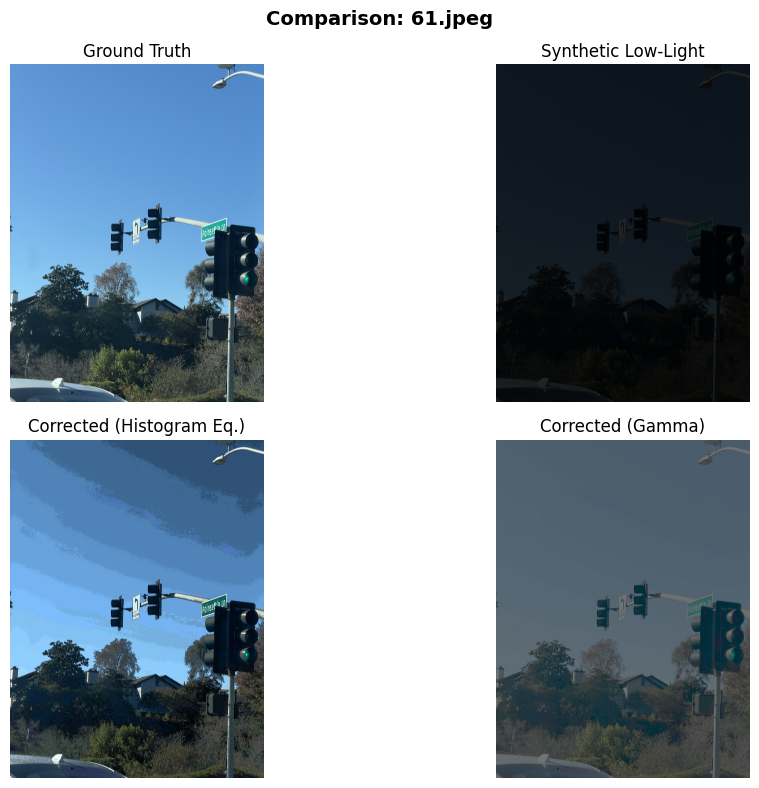


Showing comparison for 61.jpeg



In [12]:
# Select random images for comparison
import random

num_examples = min(3, len(image_files))
example_files = random.sample(image_files, num_examples)

for example_path in example_files:
    # Load images
    gt_path = gt_dir / example_path.name
    low_light = cv2.imread(str(example_path))
    ground_truth = cv2.imread(str(gt_path))
    corrected_he = cv2.imread(str(corrected_he_dir / example_path.name))
    corrected_gamma = cv2.imread(str(corrected_gamma_dir / example_path.name))
    
    if all(img is not None for img in [low_light, ground_truth, corrected_he, corrected_gamma]):
        # Create comparison figure
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle(f"Comparison: {example_path.name}", fontsize=14, fontweight='bold')
        
        axes[0,0].imshow(cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB))
        axes[0,0].set_title('Ground Truth', fontsize=12)
        axes[0,0].axis('off')
        
        axes[0,1].imshow(cv2.cvtColor(low_light, cv2.COLOR_BGR2RGB))
        axes[0,1].set_title('Synthetic Low-Light', fontsize=12)
        axes[0,1].axis('off')
        
        axes[1,0].imshow(cv2.cvtColor(corrected_he, cv2.COLOR_BGR2RGB))
        axes[1,0].set_title('Corrected (Histogram Eq.)', fontsize=12)
        axes[1,0].axis('off')
        
        axes[1,1].imshow(cv2.cvtColor(corrected_gamma, cv2.COLOR_BGR2RGB))
        axes[1,1].set_title('Corrected (Gamma)', fontsize=12)
        axes[1,1].axis('off')
        
        plt.tight_layout()
        plt.show()
        print(f"\nShowing comparison for {example_path.name}\n")

## 7. References

1. OpenCV Documentation: https://docs.opencv.org/
2. Histogram Equalization: https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
3. Gamma Correction: https://pyimagesearch.com/2015/10/05/opencv-gamma-correction/